# Working on...

#### First method is _filter()

In [22]:
import os
import wave
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="numpy._distributor_init")
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")
# This is origin code
"""
def _filter(self):
        audiopaths_and_text_new = []
        lengths = []
        for audiopath, text in self.audiopaths_and_text:
            # we filter the text with appropriate length
            if self.min_text_len <= len(text) and len(text) <= self.max_text_len:
                audiopaths_and_text_new.append([audiopath, text])
                # lengths store the length of spectrogram
                # length of spectrogram is length of audio // hop_length
                lengths.append(os.path.getsize(audiopath) // (2 * self.hop_length))
        self.audiopaths_and_text = audiopaths_and_text_new
        self.lengths = lengths
"""
# after processed by load_filepaths_and_text in data_utils and utils
# the audiopaths_and_text will be like this.

lengths = []
hop_length = 256
min_text_len = 1
max_text_len = 190 # the same as original vits code.
audiopaths_and_text = [('audio/LJ001-0001.wav','Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition')]
def _filter():
        global audiopaths_and_text, lengths
        audiopaths_and_text_new = []
        local_length = []
        for audiopath, text in audiopaths_and_text:
            # we filter the text with appropriate length
            if min_text_len <= len(text) and len(text) <= max_text_len:
                audiopaths_and_text_new.append([audiopath, text])
                # lengths store the length of spectrogram
                # length of spectrogram is length of audio // hop_length
                local_length.append(os.path.getsize(audiopath) // (2 * hop_length))
        audiopaths_and_text = audiopaths_and_text_new
        lengths = local_length
_filter()
print(lengths)

[831]


In [23]:
wavFile = r"audio/LJ001-0001.wav"
f = wave.open(wavFile)
# get params of the file
params = f.getparams()
Channels = f.getnchannels()
SampleRate = f.getframerate()
bit_type = f.getsampwidth() * 8
frames = f.getnframes()
# Duration = samplingpoints / samplingrates
Duration = wav_time = frames / float(SampleRate)  # 单位为s
print("(Channels)：", Channels)
print("(SampleRate)：", SampleRate)
print("(Precision)：", bit_type)
print("(frames)：", frames)
print("(Duration)：", Duration)
print("(bits rate): ", SampleRate*bit_type)
print("(File Size): ", frames*2)
print("(Spectrogram Length): ", frames*2 // (2 * hop_length))

(Channels)： 1
(SampleRate)： 22050
(Precision)： 16
(frames)： 212893
(Duration)： 9.65501133786848
(bits rate):  352800
(File Size):  425786
(Spectrogram Length):  831


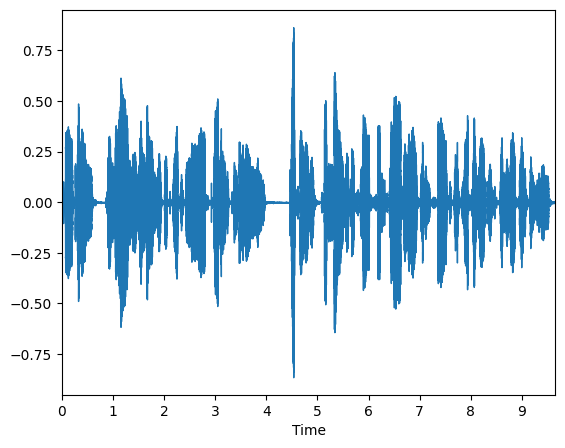

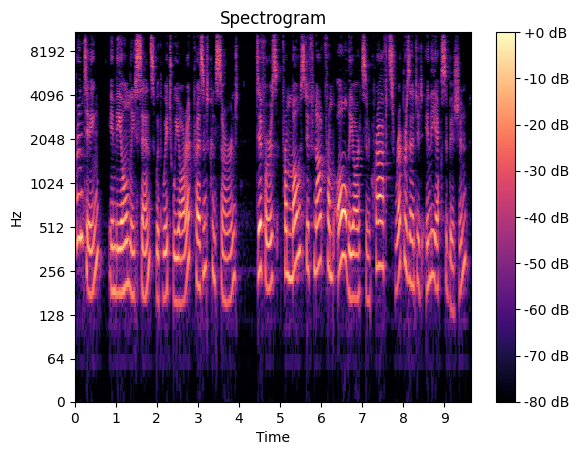

In [24]:
# Draw WaveForm
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
plt.figure(figsize=(14, 5))
y, sr = librosa.load(wavFile)
# Draw the waveform
plt.subplot(1, 2, 1)
librosa.display.waveplot(y, sr=sr)
D = librosa.stft(y, hop_length=hop_length)

# Convert the STFT to a magnitude spectrogram
spectrogram = np.abs(D)

# Display the spectrogram
plt.figure()
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                         sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

## Explanation
The length of a waveform is the number of frames, and the file size is the number of frames multiplied by 2 (each frame requires 2 bytes for storage). Furthermore, converting a waveform to a spectrum requires many small segments of the waveform (the meaning of hop_length is to convert a certain length of waveform into one unit of spectrum). Since the file size is the number of frames divided by 2, we can divide the file size by hop_length * 2, which becomes the number of frames divided by hopsize, and the final result is the length of the spectrum.

## Three Methods about geting audio and text

In [25]:
############ additional knowledge that is not necessary for you to grasp, but may be of interest to you. #############
# Cleaner of text
# For a deep understanding of what the function means
# open cleaner.ipynb
# Regular expression matching whitespace:
import re
from unidecode import unidecode
from phonemizer import phonemize
_whitespace_re = re.compile(r'\s+')

# List of (regular expression, replacement) pairs for abbreviations:
_abbreviations = [(re.compile('\\b%s\\.' % x[0], re.IGNORECASE), x[1]) for x in [
  ('mrs', 'misess'),
  ('mr', 'mister'),
  ('dr', 'doctor'),
  ('st', 'saint'),
  ('co', 'company'),
  ('jr', 'junior'),
  ('maj', 'major'),
  ('gen', 'general'),
  ('drs', 'doctors'),
  ('rev', 'reverend'),
  ('lt', 'lieutenant'),
  ('hon', 'honorable'),
  ('sgt', 'sergeant'),
  ('capt', 'captain'),
  ('esq', 'esquire'),
  ('ltd', 'limited'),
  ('col', 'colonel'),
  ('ft', 'fort'),
]]
def expand_abbreviations(text):
  for regex, replacement in _abbreviations:
    text = re.sub(regex, replacement, text)
  return text


def lowercase(text):
  return text.lower()


def collapse_whitespace(text):
  return re.sub(_whitespace_re, ' ', text)


def convert_to_ascii(text):
  return unidecode(text)


def basic_cleaners(text):
  '''Basic pipeline that lowercases and collapses whitespace without transliteration.'''
  text = lowercase(text)
  text = collapse_whitespace(text)
  return text


def transliteration_cleaners(text):
  '''Pipeline for non-English text that transliterates to ASCII.'''
  text = convert_to_ascii(text)
  text = lowercase(text)
  text = collapse_whitespace(text)
  return text


def english_cleaners2(text):
  '''Pipeline for English text, including abbreviation expansion. + punctuation + stress'''
  text = convert_to_ascii(text)
  text = lowercase(text)
  text = expand_abbreviations(text)
  phonemes = phonemize(text, language='en-us', backend='espeak', strip=True, preserve_punctuation=True, with_stress=True)
  phonemes = collapse_whitespace(phonemes)
  return phonemes

#########################The really important idea here is phonemizer. It convert words into phonetic symbol.###############################


In [26]:
##################################################EXAMPLE OF PHONEMIZER###############################################################
from phonemizer import phonemize

texts = ['hello, my name is Junity', 
        'nice to meet you!']

# Do this:
phonemized =  phonemize(texts, language='en-us')
phonemized

['həloʊ maɪ neɪm ɪz dʒuːnᵻɾi ', 'naɪs tə miːt juː ']

In [27]:
############ Convert every symbol into number, since neural network only deals with number #############
# Some text processing variables.
# No need to understand when you first time see them.
# You will understand what they mean in the following cells.
_pad        = '_'
_punctuation = ';:,.!?¡¿—…"«»“” '
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
_letters_ipa = "ɑɐɒæɓʙβɔɕçɗɖðʤəɘɚɛɜɝɞɟʄɡɠɢʛɦɧħɥʜɨɪʝɭɬɫɮʟɱɯɰŋɳɲɴøɵɸθœɶʘɹɺɾɻʀʁɽʂʃʈʧʉʊʋⱱʌɣɤʍχʎʏʑʐʒʔʡʕʢǀǁǂǃˈˌːˑʼʴʰʱʲʷˠˤ˞↓↑→↗↘'̩'ᵻ"
# Export all symbols:
symbols = [_pad] + list(_punctuation) + list(_letters) + list(_letters_ipa)
# Special symbol id
_symbol_to_id = {s: i for i, s in enumerate(symbols)}
_id_to_symbol = {i: s for i, s in enumerate(symbols)}
print(_symbol_to_id)
print(_id_to_symbol)

{'_': 0, ';': 1, ':': 2, ',': 3, '.': 4, '!': 5, '?': 6, '¡': 7, '¿': 8, '—': 9, '…': 10, '"': 11, '«': 12, '»': 13, '“': 14, '”': 15, ' ': 16, 'A': 17, 'B': 18, 'C': 19, 'D': 20, 'E': 21, 'F': 22, 'G': 23, 'H': 24, 'I': 25, 'J': 26, 'K': 27, 'L': 28, 'M': 29, 'N': 30, 'O': 31, 'P': 32, 'Q': 33, 'R': 34, 'S': 35, 'T': 36, 'U': 37, 'V': 38, 'W': 39, 'X': 40, 'Y': 41, 'Z': 42, 'a': 43, 'b': 44, 'c': 45, 'd': 46, 'e': 47, 'f': 48, 'g': 49, 'h': 50, 'i': 51, 'j': 52, 'k': 53, 'l': 54, 'm': 55, 'n': 56, 'o': 57, 'p': 58, 'q': 59, 'r': 60, 's': 61, 't': 62, 'u': 63, 'v': 64, 'w': 65, 'x': 66, 'y': 67, 'z': 68, 'ɑ': 69, 'ɐ': 70, 'ɒ': 71, 'æ': 72, 'ɓ': 73, 'ʙ': 74, 'β': 75, 'ɔ': 76, 'ɕ': 77, 'ç': 78, 'ɗ': 79, 'ɖ': 80, 'ð': 81, 'ʤ': 82, 'ə': 83, 'ɘ': 84, 'ɚ': 85, 'ɛ': 86, 'ɜ': 87, 'ɝ': 88, 'ɞ': 89, 'ɟ': 90, 'ʄ': 91, 'ɡ': 92, 'ɠ': 93, 'ɢ': 94, 'ʛ': 95, 'ɦ': 96, 'ɧ': 97, 'ħ': 98, 'ɥ': 99, 'ʜ': 100, 'ɨ': 101, 'ɪ': 102, 'ʝ': 103, 'ɭ': 104, 'ɬ': 105, 'ɫ': 106, 'ɮ': 107, 'ʟ': 108, 'ɱ': 109, 'ɯ': 110,

In [45]:
import torch
from scipy.io.wavfile import read
max_wav_value = 32768.0
sampling_rate = 22050
filter_length = 1024
hop_length = 256
win_length = 1024
n_mel_channels = 80
text_cleaners = ['english_cleaners2']
hann_window = {}
# A method that call get_text and get_audio, return text, spectrogram, and audio(frequency domain).
def get_audio_text_pair(audiopath_and_text):
    # separate filename and text
    audiopath, text = audiopath_and_text[0], audiopath_and_text[1]
    text = get_text(text)
    spec, wav = get_audio(audiopath)
    return (text, spec, wav)

######################### get_audio ###############################

def get_audio(filename):
    audio, sampling_rate = load_wav_to_torch(filename) # read audio.
    audio_norm = audio / max_wav_value # normalize
    audio_norm = audio_norm.unsqueeze(0) # add channel
    #spec filename should be the same with audio, with .spec.pt
    spec_filename = filename.replace(".wav", ".spec.pt") 
    
    if os.path.exists(spec_filename): # skip if already exists
        spec = torch.load(spec_filename)
    else:
        spec = spectrogram_torch(audio_norm, filter_length,
            sampling_rate, hop_length, win_length,
            center=False) # read spectrogram from audio, method is at below.
        spec = torch.squeeze(spec, 0)
        torch.save(spec, spec_filename) # save as .spec.pt
    return spec, audio_norm

###################### get_text ###############################

def get_text(text):
#        if self.cleaned_text:
#            text_norm = cleaned_text_to_sequence(text)
#        else:
    
    text_norm = text_to_sequence(text, text_cleaners)
    
    # After cleaning, the text should be looked from
    # Mrs. De Mohrenschildt thought that Oswald,
    # to
    # mɪsˈɛs də mˈoʊɹɪnstʃˌaɪlt θˈɔːt ðæt ˈɑːswəld,
    
    # if self.add_blank:
        # text_norm = commons.intersperse(text_norm, 0)
    
    text_norm = torch.LongTensor(text_norm)
    return text_norm


#####################SUPPORT FUNCTION############################
#####################SUPPORT FUNCTION############################

# The following are the support functions for get_audio_text_pair
def spectrogram_torch(y, n_fft, sampling_rate, hop_size, win_size, center=False):
    # after normalizing, y should not be larger than 1 and smaller than -1.
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global hann_window
    dtype_device = str(y.dtype) + '_' + str(y.device)
    wnsize_dtype_device = str(win_size) + '_' + dtype_device
    if wnsize_dtype_device not in hann_window:
        # stores hann_window function values.
        # further examples will be in the next cell.
        hann_window[wnsize_dtype_device] = torch.hann_window(win_size).to(dtype=y.dtype, device=y.device)

    # padding, and will have further explanation in the next cell.
    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    # Short-time Fourier transform (STFT). Converting audio to frequency domain.
    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[wnsize_dtype_device],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=False)
    # normalizing the spectrogram, and add 1e-6 in case of log(0)
    spec = torch.sqrt(spec.pow(2).sum(-1) + 1e-6)
    return spec

#################### load_wav_to_torch ##########################

def load_wav_to_torch(full_path):
  sampling_rate, data = read(full_path)
  return torch.FloatTensor(data.astype(np.float32)), sampling_rate

#################### text_to_sequence ############################

def text_to_sequence(text, cleaner_names):
  '''Converts a string of text to a sequence of IDs corresponding to the symbols in the text.
    Args:
      text: string to convert to a sequence
      cleaner_names: names of the cleaner functions to run the text through
    Returns:
      List of integers corresponding to the symbols in the text
  '''
  sequence = []

  clean_text = _clean_text(text, cleaner_names)
  
  # convert cleaned text to sequence like [1, 3, 5]
  for symbol in clean_text:
    symbol_id = _symbol_to_id[symbol]
    sequence += [symbol_id] 
  return sequence
  ################## _clean_text #############################

def _clean_text(text, cleaner_names):
  for name in cleaner_names:
    #cleaner = getattr(cleaners, name)
    #if not cleaner:
    #  raise Exception('Unknown cleaner: %s' % name)
    #text = cleaner(text)
    
    # call function by string: name
    # text = eval(name+'()')(text)
    # Get the function from the global namespace
        cleaner = globals().get(name)
        
        # Check if the cleaner function exists
        if cleaner is None:
            raise Exception('Unknown cleaner: %s' % name)
        
        # Call the cleaner function with the text argument
        text = cleaner(text)
  return text

In [50]:
get_audio_text_pair(audiopaths_and_text[0])

(tensor([ 58, 123, 156, 102,  56,  62, 102, 112,   3,  16, 102,  56,  81, 102,
          16, 156,  57, 135,  56,  54,  51,  16,  61, 156,  86,  56,  61,  16,
          65, 102,  81,  16,  65, 157, 102,  62, 131,  16,  65,  51, 158,  16,
          69, 158, 123,  16,  72,  62,  16,  58, 123, 156,  86,  68,  83,  56,
          62,  16,  53,  83,  56,  61, 156,  87, 158,  56,  46,   3,  16,  46,
         156, 102,  48,  85,  68,  16,  48, 123, 138,  55,  16,  55, 156,  57,
         135,  61,  62,  16, 102,  48,  16,  56, 157,  69, 158,  62,  16,  48,
         123, 138,  55,  16, 156,  76, 158,  54,  16,  81, 102,  16, 156,  69,
         158, 123,  62,  61,  16,  72,  56,  46,  16,  53, 123, 156,  72,  48,
          62,  61,  16, 123, 157,  86,  58, 123, 177,  68, 156,  86,  56,  62,
         177,  46,  16, 102,  56,  81, 102,  16,  86,  53,  61, 102,  44, 156,
         102, 131,  83,  56]),
 tensor([[0.0026, 0.0100, 0.0092,  ..., 0.0011, 0.0017, 0.0026],
         [0.0020, 0.0103, 0.0124,  